In [1]:
import os
import pandas as pd
import geopandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder

# Load Data

In [3]:
DATA_PATH = "data/"

In [4]:
files = os.listdir(DATA_PATH)

In [5]:
test_data = pd.read_csv(DATA_PATH+"test_eph_data_20210623_20210801_1m.csv")

In [6]:
data = []
for file in files:
    if file.startswith("train_data_"):
        data.append(pd.read_csv(DATA_PATH+file))

train_data = pd.concat(data, axis=0, ignore_index=True)

In [7]:
train_data.head(5)

,targetname,datetime_jd,solar_presence,flags,AZ,EL,datetime,hour,lon,lat,alt
0,Moon (301),2.459216e+06,*,NaN,60.274557,-17.683876,2021-01-01 00:00:00.000,0,-90.352191,13.953282,26.0
1,Moon (301),2.459216e+06,N,NaN,62.229173,-13.201599,2021-01-01 00:22:01.099,0,-90.352191,13.953282,26.0
2,Moon (301),2.459216e+06,A,NaN,63.952508,-8.635545,2021-01-01 00:44:02.199,0,-90.352191,13.953282,26.0
3,Moon (301),2.459216e+06,NaN,r,65.472640,-3.998341,2021-01-01 01:06:03.298,1,-90.352191,13.953282,26.0
4,Moon (301),2.459216e+06,NaN,m,66.811750,0.699646,2021-01-01 01:28:04.398,1,-90.352191,13.953282,26.0


In [8]:
train_data.shape

test_data.head(5)

,targetname,datetime_jd,solar_presence,flags,AZ,EL,datetime,hour,lon,lat,alt
0,Moon (301),2.459388e+06,*,m,118.164545,16.334906,2021-06-23 00:00:00,0,-90.579262,14.536296,1338.0
1,Moon (301),2.459389e+06,*,m,118.262177,16.539676,2021-06-23 00:01:00,0,-90.579262,14.536296,1338.0
2,Moon (301),2.459389e+06,*,m,118.360351,16.744268,2021-06-23 00:02:00,0,-90.579262,14.536296,1338.0
3,Moon (301),2.459389e+06,*,m,118.459070,16.948678,2021-06-23 00:03:00,0,-90.579262,14.536296,1338.0
4,Moon (301),2.459389e+06,*,m,118.558338,17.152906,2021-06-23 00:04:00,0,-90.579262,14.536296,1338.0


In [9]:
test_data.shape

(57600, 11)

## Data Cleanup and Exploration

### Locations

In [10]:
locations = train_data[['lat', 'lon', 'alt']].drop_duplicates().copy()
locations.reset_index(drop=True, inplace=True)
locations['location']= 'location_'+ locations.index.astype(str)

In [11]:
gdf = geopandas.GeoDataFrame(
    locations, 
    geometry=geopandas.points_from_xy(locations.lon, locations.lat)
)

Text(76.92836226749236, 0.5, 'Latitud')

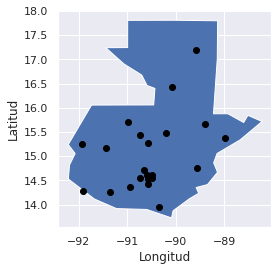

In [12]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world[world.name == 'Guatemala'].plot()
gdf.plot(ax=ax, color='black')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

### Time Features

In [13]:
train_data['datetime'] = pd.to_datetime(train_data['datetime'], utc=True)

In [14]:
train_data['datetime_GT'] = train_data['datetime'].dt.tz_convert('America/Guatemala')

In [15]:
train_data.shape

(249330, 12)

In [16]:
#train_data = train_data[train_data.solar_presence.isnull()]

In [17]:
train_data.shape

(249330, 12)

In [18]:
train_data['year'] = train_data['datetime_GT'].dt.year
train_data['mes'] = train_data['datetime_GT'].dt.month
train_data['dia'] = train_data['datetime_GT'].dt.day
train_data['hora'] = train_data['datetime_GT'].dt.hour
train_data['minuto'] = train_data['datetime_GT'].dt.minute
train_data['segundo'] = train_data['datetime_GT'].dt.second
train_data['dia_anio'] = train_data['datetime_GT'].dt.dayofyear
train_data['semana_anio'] = train_data['datetime_GT'].dt.isocalendar().week

In [19]:
train_data['hora_float'] = train_data.hora + train_data.minuto/60 + train_data.segundo
train_data['sen_tiempo']=np.sin(2.*np.pi*train_data.hora_float/24.)
train_data['cos_tiempo']=np.cos(2.*np.pi*train_data.hora_float/24.)

Text(0, 0.5, 'coseno')

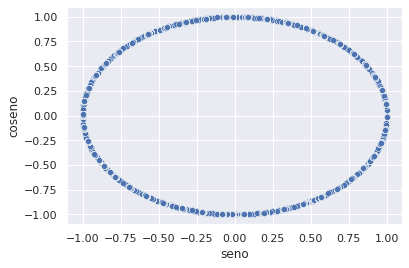

In [20]:
sns.scatterplot(x='sen_tiempo', y='cos_tiempo', data=train_data)
plt.xlabel('seno')
plt.ylabel('coseno')

In [21]:
train_data['sen_dia']=np.sin(2.*np.pi*train_data.dia/30)
train_data['cos_dia']=np.cos(2.*np.pi*train_data.dia/30)

In [22]:
train_data['sen_dia_anio']=np.sin(2.*np.pi*train_data.dia_anio/365)
train_data['cos_dia_anio']=np.cos(2.*np.pi*train_data.dia_anio/365)

Text(0, 0.5, 'Dia del año')

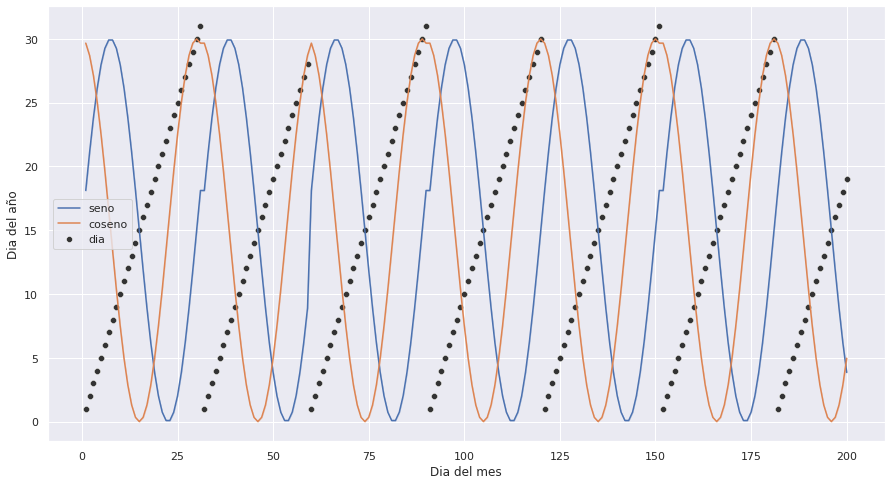

In [23]:
tmp = train_data[train_data.dia_anio <= 200].copy()
tmp['sen_dia'] = 15*tmp['sen_dia']+15
tmp['cos_dia'] = 15*tmp['cos_dia']+15
plt.figure(figsize = (15,8))
sns.lineplot(data=tmp, x='dia_anio', y='sen_dia', label="seno")
sns.lineplot(data=tmp, x='dia_anio', y='cos_dia', label="coseno")
sns.scatterplot(data=tmp, x='dia_anio', y='dia', label="dia", color=".2")
plt.xlabel('Dia del mes')
plt.ylabel('Dia del año')

In [24]:
train_data[train_data.year == 2020].semana_anio.unique()

<IntegerArray>
[53, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
 49, 50, 51, 52]
Length: 23, dtype: UInt32

# Feature Selection

In [25]:
train_data.columns

Index(['targetname', 'datetime_jd', 'solar_presence', 'flags', 'AZ', 'EL',
       'datetime', 'hour', 'lon', 'lat', 'alt', 'datetime_GT', 'year', 'mes',
       'dia', 'hora', 'minuto', 'segundo', 'dia_anio', 'semana_anio',
       'hora_float', 'sen_tiempo', 'cos_tiempo', 'sen_dia', 'cos_dia',
       'sen_dia_anio', 'cos_dia_anio'],
      dtype='object')

In [26]:
categorical_features = ['hora']

continuous_features = ['lon', 'lat', 'alt','sen_tiempo', 'cos_tiempo', 
                       'sen_dia', 'cos_dia']

In [27]:
features = np.append(categorical_features, continuous_features)

In [28]:
cat_pipe = Pipeline([
    ("onehot_cats", OneHotEncoder())
])

preprocess_pipeline = ColumnTransformer([  
    ('categorical', cat_pipe, categorical_features),
    
], remainder='passthrough')

In [29]:
train = train_data[train_data.datetime_GT < '2021-07-01 00:00:00'].copy()
validation = train_data[train_data.datetime_GT >= '2021-07-01 00:00:00'].copy()

In [30]:
x_train = preprocess_pipeline.fit_transform(train[features])

In [31]:
el_train = train['EL']
el_validation = validation['EL']

In [32]:
az_train = train['AZ']
az_validation = validation['AZ']

# Elevation Model

### Hyperparameters

params = {
    'n_estimators': 700,
    'learning_rate': 0.5,
    'max_depth': 11,
    'eval_metric': 'rmse',
    'n_jobs': 4,
    'reg_alpha': 0.9,
    'reg_lambda': 15,
    'gpu_id': 0
}

In [33]:
params = {
    'n_estimators': 1000,
    'learning_rate': 0.5,
    'max_depth': 15,
    'eval_metric': 'rmse',
    'n_jobs': 8,
    'reg_alpha': 0.95,
    'reg_lambda': 20,
    'gpu_id': 0
}

In [34]:
model_el = XGBRegressor(**params)
model_el.fit(x_train, el_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, gpu_id=0, importance_type='gain',
             interaction_constraints='', learning_rate=0.5, max_delta_step=0,
             max_depth=15, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, random_state=0, reg_alpha=0.95, reg_lambda=20,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

## Test Elevation Model

In [35]:
x_validation = preprocess_pipeline.transform(validation[features].copy())

In [36]:
elevation_pred = model_el.predict(x_validation)

In [37]:
validation['pred_elevation'] = elevation_pred

In [38]:
rmse = mean_squared_error(el_validation, elevation_pred, squared=False)
mae = mean_absolute_error(el_validation, elevation_pred)
print(f'RMSE of prediction is: {rmse:.2f}' )
print(f'MAE of prediction is: {mae:.2f}' )

RMSE of prediction is: 18.66
MAE of prediction is: 16.18


<AxesSubplot:xlabel='datetime'>

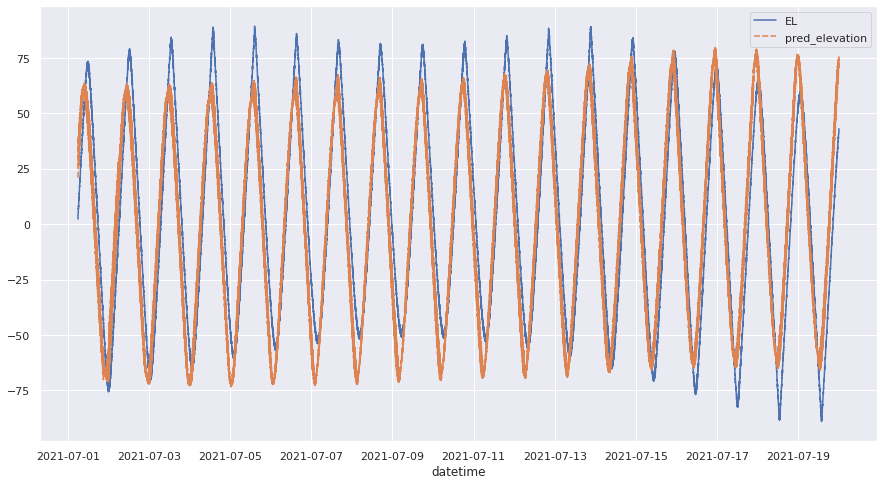

In [39]:
tmp = validation[['datetime', 'EL', 'pred_elevation']].copy()
tmp.set_index('datetime', inplace=True)

plt.figure(figsize = (15,8))
sns.lineplot(data=tmp, estimator=None)

# Modelo Azimut 

In [40]:
model_az = XGBRegressor(**params)
model_az.fit(x_train, az_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, gpu_id=0, importance_type='gain',
             interaction_constraints='', learning_rate=0.5, max_delta_step=0,
             max_depth=15, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, random_state=0, reg_alpha=0.95, reg_lambda=20,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

## Test Azimut Model

In [41]:
x_validation = preprocess_pipeline.transform(validation[features].copy())

In [42]:
azimut_pred = model_az.predict(x_validation)

In [43]:
validation['pred_azimut'] = azimut_pred

In [44]:
rmse = mean_squared_error(az_validation, azimut_pred, squared=False)
mae = mean_absolute_error(az_validation, azimut_pred)
print(f'RMSE of prediction is: {rmse:.2f}' )
print(f'MAE of prediction is: {mae:.2f}' )

RMSE of prediction is: 65.93
MAE of prediction is: 44.07


<AxesSubplot:xlabel='datetime'>

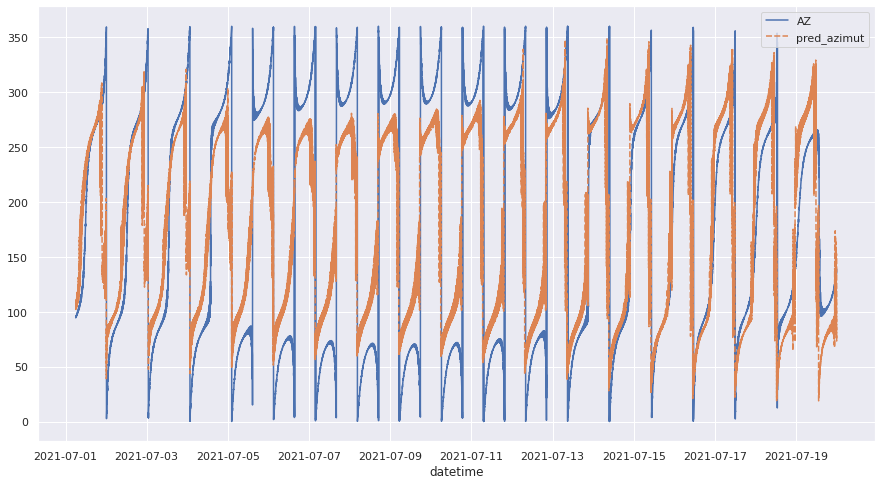

In [45]:
tmp = validation[['datetime', 'AZ', 'pred_azimut']].copy()
tmp.set_index('datetime', inplace=True)

plt.figure(figsize = (15,8))
sns.lineplot(data=tmp, estimator=None)

## Feature Importance

In [83]:
features_ = np.array(['longitud', 'latitud', 'altitud','sen_tiempo', 'cos_tiempo', 'sen_dia', 'cos_dia'])

In [60]:
az_features_importnace = model_az.feature_importances_

In [71]:
az_features_importnace.sum()

1.0

In [79]:
sort_idx = az_features_importnace[-7:].argsort()

<AxesSubplot:>

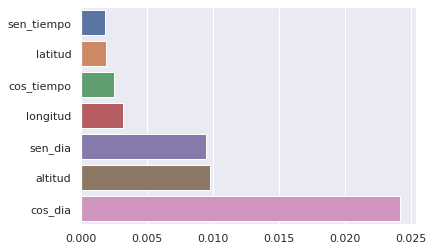

In [84]:
sns.barplot(x=az_features_importnace[-7:][sort_idx], y=features_[sort_idx])

In [87]:
el_features_importnace = model_el.feature_importances_

In [88]:
sort_idx = el_features_importnace[-7:].argsort()

<AxesSubplot:>

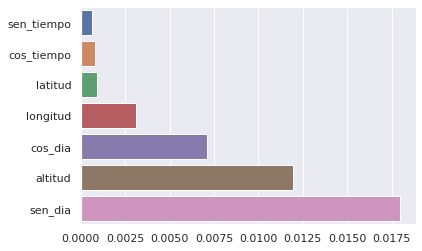

In [89]:
sns.barplot(x=el_features_importnace[-7:][sort_idx], y=features_[sort_idx])

# Test Model

In [46]:
test_data['datetime'] = pd.to_datetime(test_data['datetime'], utc=True)
test_data['datetime_GT'] = test_data['datetime'].dt.tz_convert('America/Guatemala')

In [47]:
test_data['year'] = test_data['datetime_GT'].dt.year
test_data['mes'] = test_data['datetime_GT'].dt.month
test_data['dia'] = test_data['datetime_GT'].dt.day
test_data['hora'] = test_data['datetime_GT'].dt.hour
test_data['minuto'] = test_data['datetime_GT'].dt.minute
test_data['segundo'] = test_data['datetime_GT'].dt.second
test_data['dia_anio'] = test_data['datetime_GT'].dt.dayofyear

In [48]:
test_data['hora_float'] = test_data.hora + test_data.minuto/60 + test_data.segundo
test_data['sen_tiempo']=np.sin(2.*np.pi*test_data.hora_float/24.)
test_data['cos_tiempo']=np.cos(2.*np.pi*test_data.hora_float/24.)

In [49]:
test_data['sen_dia']=np.sin(2.*np.pi/30*test_data.dia)
test_data['cos_dia']=np.cos(2.*np.pi/30*test_data.dia)

In [50]:
test = test_data[(test_data.datetime_GT >= '2021-06-25') &
                (test_data.datetime_GT < '2021-07-01') ].copy()

In [51]:
x_test = preprocess_pipeline.transform(test[features].copy())

In [52]:
elevation_pred = model_el.predict(x_test)
azimut_pred = model_az.predict(x_test)

In [53]:
test['pred_azimut'] = azimut_pred
test['pred_elevation'] = elevation_pred

<AxesSubplot:xlabel='datetime_GT'>

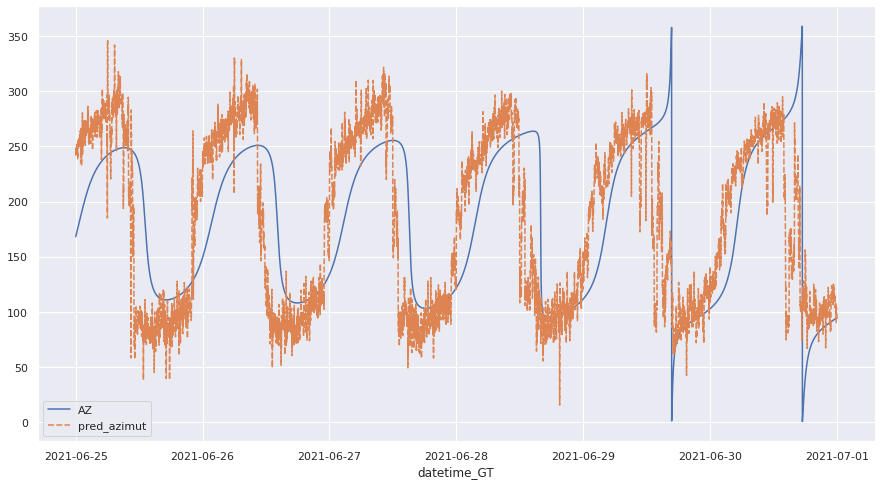

In [54]:
tmp = test[['datetime_GT', 'AZ', 'pred_azimut']].copy()
tmp.set_index('datetime_GT', inplace=True)

plt.figure(figsize = (15,8))
sns.lineplot(data=tmp, estimator=None)

<AxesSubplot:xlabel='datetime_GT'>

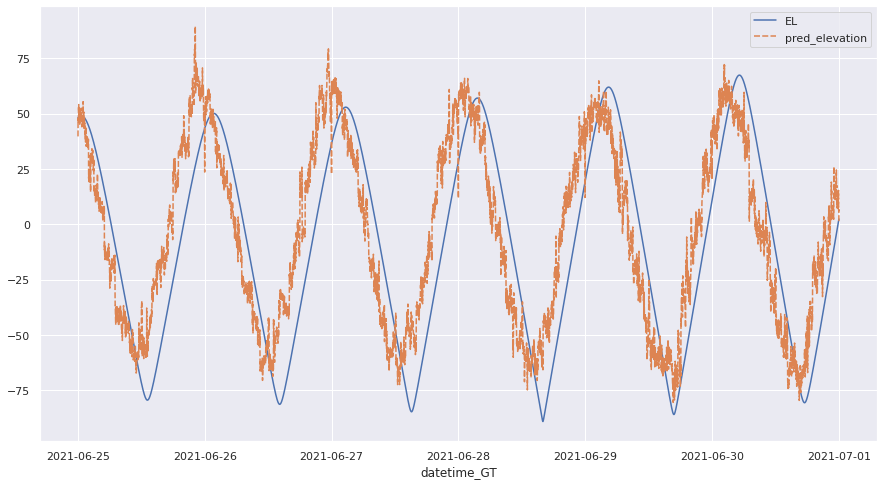

In [55]:
tmp = test[['datetime_GT', 'EL', 'pred_elevation']].copy()
tmp.set_index('datetime_GT', inplace=True)

plt.figure(figsize = (15,8))
sns.lineplot(data=tmp, estimator=None)

In [56]:
test[['datetime_GT', 'hora_float','EL', 'pred_elevation']]

,datetime_GT,hora_float,EL,pred_elevation
3240,2021-06-25 00:00:00-06:00,0.000000,48.160542,39.689308
3241,2021-06-25 00:01:00-06:00,0.016667,48.208202,47.958263
3242,2021-06-25 00:02:00-06:00,0.033333,48.254571,45.811302
3243,2021-06-25 00:03:00-06:00,0.050000,48.299644,46.039661
3244,2021-06-25 00:04:00-06:00,0.066667,48.343416,46.958523
...,...,...,...,...
11875,2021-06-30 23:55:00-06:00,23.916667,1.446219,15.294465
11876,2021-06-30 23:56:00-06:00,23.933333,1.681730,9.386712
11877,2021-06-30 23:57:00-06:00,23.950000,1.917243,6.006904
11878,2021-06-30 23:58:00-06:00,23.966667,2.152758,6.679483


In [57]:
test[['datetime_GT', 'hora_float','AZ', 'pred_azimut']]

,datetime_GT,hora_float,AZ,pred_azimut
3240,2021-06-25 00:00:00-06:00,0.000000,168.159142,241.549561
3241,2021-06-25 00:01:00-06:00,0.016667,168.480101,248.653168
3242,2021-06-25 00:02:00-06:00,0.033333,168.801784,242.970200
3243,2021-06-25 00:03:00-06:00,0.050000,169.124175,247.688705
3244,2021-06-25 00:04:00-06:00,0.066667,169.447255,243.389923
...,...,...,...,...
11875,2021-06-30 23:55:00-06:00,23.916667,94.296588,95.337616
11876,2021-06-30 23:56:00-06:00,23.933333,94.354795,93.435814
11877,2021-06-30 23:57:00-06:00,23.950000,94.413086,97.510597
11878,2021-06-30 23:58:00-06:00,23.966667,94.471465,92.606949


In [58]:
test.columns

Index(['targetname', 'datetime_jd', 'solar_presence', 'flags', 'AZ', 'EL',
       'datetime', 'hour', 'lon', 'lat', 'alt', 'datetime_GT', 'year', 'mes',
       'dia', 'hora', 'minuto', 'segundo', 'dia_anio', 'hora_float',
       'sen_tiempo', 'cos_tiempo', 'sen_dia', 'cos_dia', 'pred_azimut',
       'pred_elevation'],
      dtype='object')